Paso 1: Importaciones y configuración

In [2]:
import os
import glob
import rasterio
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from rasterio.plot import show

# Configuración de rutas relativas (asumiendo que el notebook está en /notebooks)
RAW_DIR = "../data/raw"
FIGURE_DIR = "../outputs/figures"

print("✅ Librerías importadas y rutas configuradas.")

✅ Librerías importadas y rutas configuradas.


Exploración de rasters (viento, vegetación, altura)

In [2]:
# Diccionario con tus archivos raster clave
rasters = {
    "Viento (ERA5)": os.path.join(RAW_DIR, "era5_wind_valdivia.tif"),
    "Vegetación (Sentinel-2)": os.path.join(RAW_DIR, "sentinel2_valdivia.tif"),
    "Topología (SRTM)": os.path.join(RAW_DIR, "srtm_valdivia.tif") # Corregí strm a srtm
}

print("--- METADATA DE RASTERS ---")
for nombre, ruta in rasters.items():
    if os.path.exists(ruta):
        with rasterio.open(ruta) as src:
            print(f"📂 {nombre}:")
            print(f"   - Sistema de Coordenadas (CRS): {src.crs}")
            print(f"   - Tamaño: {src.width}x{src.height} píxeles")
            print(f"   - Bandas: {src.count}")
            print(f"   - Tipo de dato: {src.dtypes[0]}")
            print("-" * 30)
    else:
        print(f"❌ NO ENCONTRADO: {nombre} en {ruta}")

--- METADATA DE RASTERS ---
📂 Viento (ERA5):
   - Sistema de Coordenadas (CRS): EPSG:4326
   - Tamaño: 16x16 píxeles
   - Bandas: 2
   - Tipo de dato: float64
------------------------------
📂 Vegetación (Sentinel-2):
   - Sistema de Coordenadas (CRS): EPSG:32718
   - Tamaño: 1228x1467 píxeles
   - Bandas: 4
   - Tipo de dato: uint16
------------------------------
📂 Topología (SRTM):
   - Sistema de Coordenadas (CRS): EPSG:4326
   - Tamaño: 521x484 píxeles
   - Bandas: 1
   - Tipo de dato: int16
------------------------------



Estadísticas para Viento (ERA5):
  Banda 1: min=0.30, max=1.26, mean=0.64


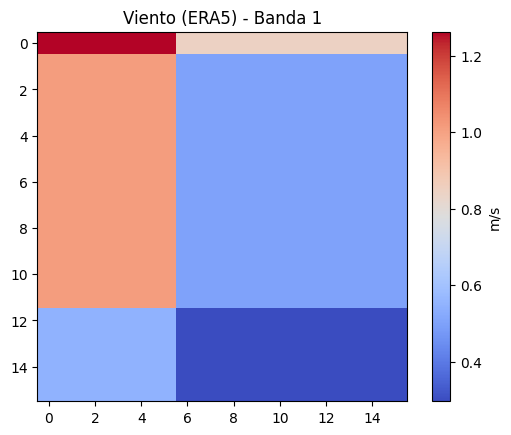

  Banda 2: min=1.94, max=2.55, mean=2.09


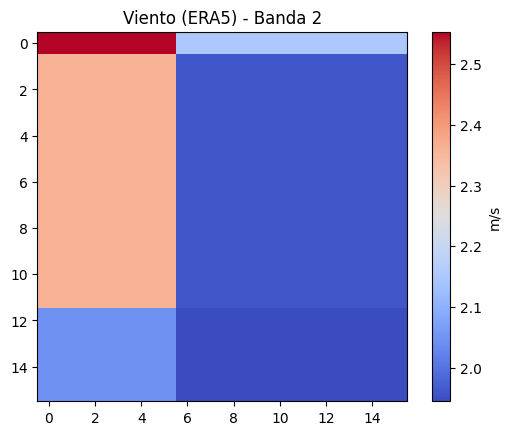

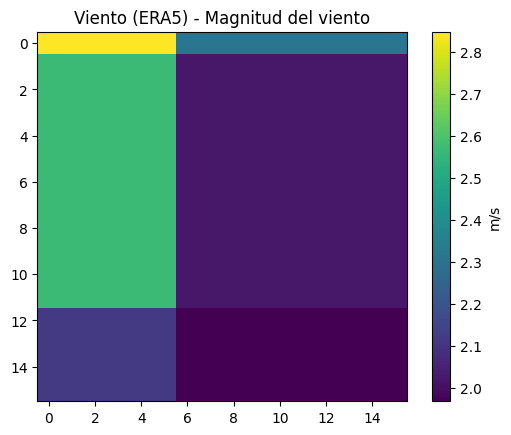


Estadísticas para Vegetación (Sentinel-2):


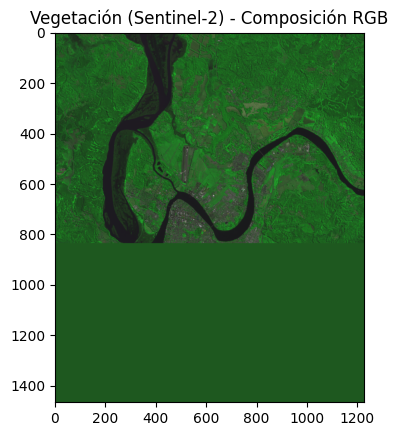

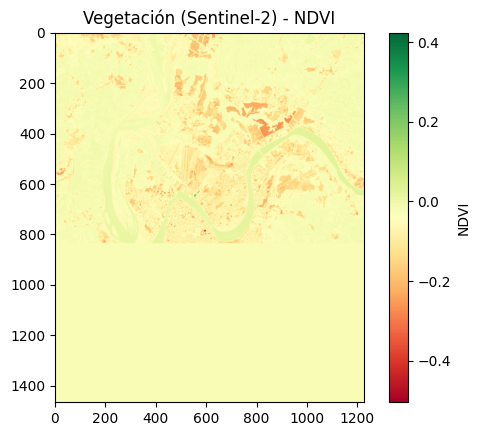

  NDVI: min=-0.50, max=0.42, mean=-0.04

Estadísticas para Topología (SRTM):


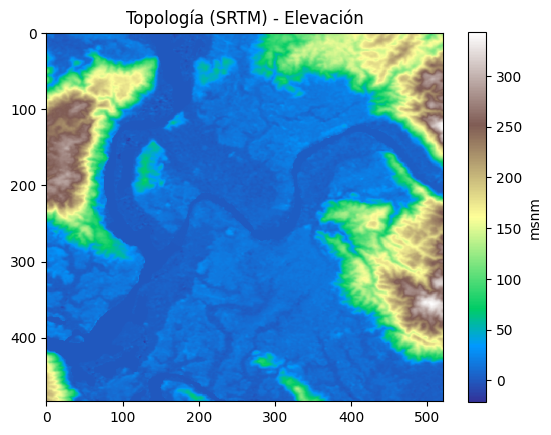

  Elevación: min=-21, max=343, mean=52.27


In [3]:
# Crear carpeta FIGURE_DIR si no existe
os.makedirs(FIGURE_DIR, exist_ok=True)

for nombre, ruta in rasters.items():
    if os.path.exists(ruta):
        with rasterio.open(ruta) as src:
            data = src.read()
            print(f"\nEstadísticas para {nombre}:")
            
            # --- ERA5 Viento ---
            if "Viento" in nombre:
                for i in range(src.count):
                    band = data[i]
                    print(f"  Banda {i+1}: min={band.min():.2f}, max={band.max():.2f}, mean={band.mean():.2f}")
                    plt.imshow(band, cmap="coolwarm")
                    plt.title(f"{nombre} - Banda {i+1}")
                    plt.colorbar(label="m/s")
                    # Guardar figura
                    fname = f"{nombre.replace(' ', '_').lower()}_banda{i+1}.png"
                    plt.savefig(os.path.join(FIGURE_DIR, fname), dpi=300, bbox_inches="tight")
                    plt.show()
                # Magnitud del viento
                u, v = data
                mag = np.sqrt(u**2 + v**2)
                plt.imshow(mag, cmap="viridis")
                plt.title(f"{nombre} - Magnitud del viento")
                plt.colorbar(label="m/s")
                fname = f"{nombre.replace(' ', '_').lower()}_magnitud.png"
                plt.savefig(os.path.join(FIGURE_DIR, fname), dpi=300, bbox_inches="tight")
                plt.show()

            # --- Vegetación Sentinel-2 ---
            elif "Vegetación" in nombre:
                rgb = np.dstack([data[0], data[1], data[2]])
                plt.imshow(rgb / np.max(rgb))
                plt.title(f"{nombre} - Composición RGB")
                fname = f"{nombre.replace(' ', '_').lower()}_rgb.png"
                plt.savefig(os.path.join(FIGURE_DIR, fname), dpi=300, bbox_inches="tight")
                plt.show()
                # NDVI
                nir = data[3].astype(float)
                red = data[0].astype(float)
                ndvi = (nir - red) / (nir + red + 1e-6)
                plt.imshow(ndvi, cmap="RdYlGn")
                plt.title(f"{nombre} - NDVI")
                plt.colorbar(label="NDVI")
                fname = f"{nombre.replace(' ', '_').lower()}_ndvi.png"
                plt.savefig(os.path.join(FIGURE_DIR, fname), dpi=300, bbox_inches="tight")
                plt.show()
                print(f"  NDVI: min={ndvi.min():.2f}, max={ndvi.max():.2f}, mean={ndvi.mean():.2f}")

            # --- Topología SRTM ---
            elif "Topología" in nombre:
                elev = data[0]
                plt.imshow(elev, cmap="terrain")
                plt.title(f"{nombre} - Elevación")
                plt.colorbar(label="msnm")
                fname = f"{nombre.replace(' ', '_').lower()}_elevacion.png"
                plt.savefig(os.path.join(FIGURE_DIR, fname), dpi=300, bbox_inches="tight")
                plt.show()
                print(f"  Elevación: min={elev.min()}, max={elev.max()}, mean={elev.mean():.2f}")


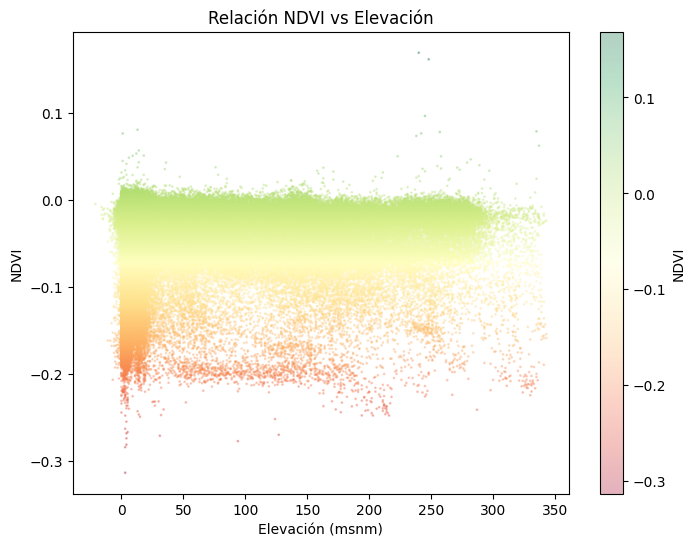

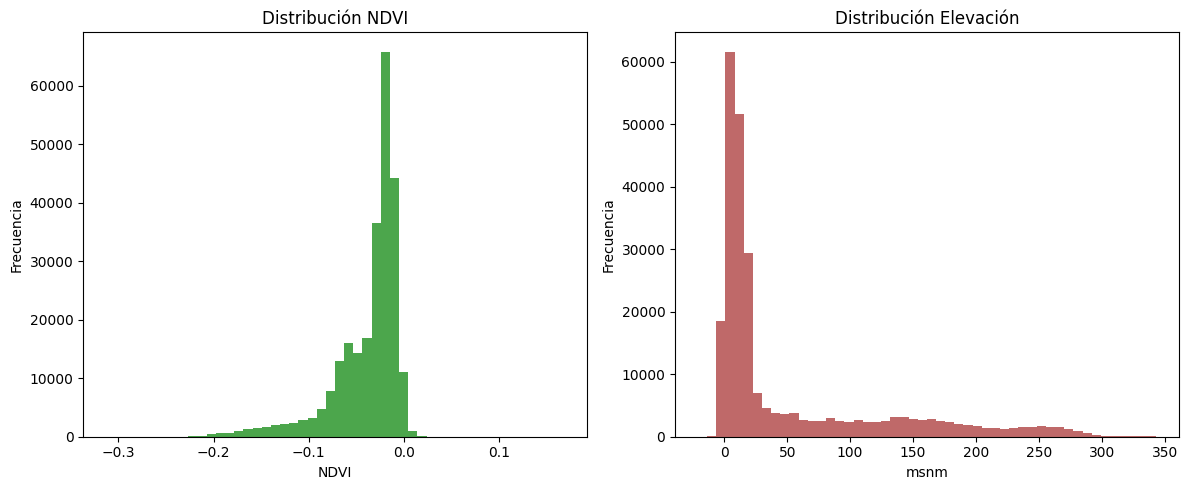

In [4]:
# --- NDVI (Sentinel-2) ---
with rasterio.open(rasters["Vegetación (Sentinel-2)"]) as src:
    data = src.read()
    nir = data[3].astype(float)
    red = data[0].astype(float)
    ndvi = (nir - red) / (nir + red + 1e-6)

# --- Elevación (SRTM) ---
with rasterio.open(rasters["Topología (SRTM)"]) as src:
    elev = src.read(1).astype(float)

# --- Ajuste de dimensiones ---
min_shape = (min(ndvi.shape[0], elev.shape[0]), min(ndvi.shape[1], elev.shape[1]))
ndvi_crop = ndvi[:min_shape[0], :min_shape[1]]
elev_crop = elev[:min_shape[0], :min_shape[1]]

# Crear carpeta FIGURE_DIR si no existe
os.makedirs(FIGURE_DIR, exist_ok=True)

# --- Scatter plot NDVI vs Elevación ---
plt.figure(figsize=(8,6))
plt.scatter(elev_crop.flatten(), ndvi_crop.flatten(), s=1, alpha=0.3,
            c=ndvi_crop.flatten(), cmap="RdYlGn")
plt.xlabel("Elevación (msnm)")
plt.ylabel("NDVI")
plt.title("Relación NDVI vs Elevación")
plt.colorbar(label="NDVI")

# Guardar figura
scatter_path = os.path.join(FIGURE_DIR, "ndvi_vs_elevacion_scatter.png")
plt.savefig(scatter_path, dpi=300, bbox_inches="tight")
plt.show()

# --- Histogramas comparativos ---
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.hist(ndvi_crop.flatten(), bins=50, color="green", alpha=0.7)
plt.title("Distribución NDVI")
plt.xlabel("NDVI")
plt.ylabel("Frecuencia")

plt.subplot(1,2,2)
plt.hist(elev_crop.flatten(), bins=50, color="brown", alpha=0.7)
plt.title("Distribución Elevación")
plt.xlabel("msnm")
plt.ylabel("Frecuencia")

plt.tight_layout()

# Guardar figura
hist_path = os.path.join(FIGURE_DIR, "ndvi_elevacion_histogramas.png")
plt.savefig(hist_path, dpi=300, bbox_inches="tight")
plt.show()


Exploración de CONAF (Amenaza y Riesgo)

--- EXPLORACIÓN VECTORIAL CONAF ---
✅ Amenaza cargada. Filas: 941695
Columnas disponibles: ['Id', 'gridcode', 'geometry']


,Id,gridcode,geometry
0,1,3,"POLYGON ((166489.924 5644161.752, 166499.924 5..."
1,2,4,"POLYGON ((166559.924 5644141.752, 166489.924 5..."
2,3,3,"POLYGON ((166559.924 5644141.752, 166559.924 5..."


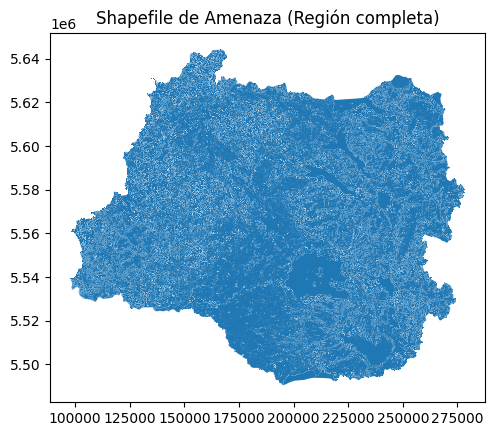

Distribución de niveles de amenaza (Polígonos):
gridcode
0     29754
1    397632
2    218591
3    231614
4     64104
Name: count, dtype: int64


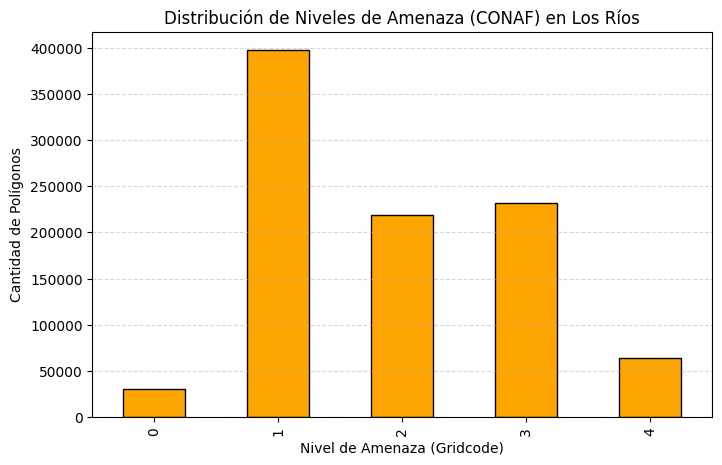

💡 Interpretación: Este gráfico nos dice si la región es mayoritariamente segura o peligrosa.


In [6]:
# Rutas a los shapefiles de CONAF (basado en tu estructura)
# Nota: Geopandas busca automáticamente los archivos .shx, .dbf, .prj si están en la misma carpeta.
path_amenaza = os.path.join(RAW_DIR, "conaf_amenaza/shapefiles/14_amenaza_shape.shp")
path_riesgo = os.path.join(RAW_DIR, "conaf_riesgo/shapefiles/14_riesgo_shape.shp")

print("--- EXPLORACIÓN VECTORIAL CONAF ---")

if os.path.exists(path_amenaza):
    gdf_amenaza = gpd.read_file(path_amenaza)
    print(f"✅ Amenaza cargada. Filas: {len(gdf_amenaza)}")
    print("Columnas disponibles:", gdf_amenaza.columns.tolist())
    # Mostrar las primeras filas para ver qué datos trae
    display(gdf_amenaza.head(3)) 
    
    # Visualización rápida del mapa
    gdf_amenaza.plot()
    plt.title("Shapefile de Amenaza (Región completa)")
    plt.show()
else:
    print(f"❌ No se encontró el archivo de Amenaza: {path_amenaza}")


# --- ESTADÍSTICAS DE AMENAZA (CONAF) ---
# Contamos cuántos polígonos hay por cada nivel de amenaza (gridcode)
if 'gridcode' in gdf_amenaza.columns:
    conteo_amenaza = gdf_amenaza['gridcode'].value_counts().sort_index()
    
    print("Distribución de niveles de amenaza (Polígonos):")
    print(conteo_amenaza)

    # Gráfico de Torta o Barras
    plt.figure(figsize=(8, 5))
    conteo_amenaza.plot(kind='bar', color='orange', edgecolor='black')
    plt.title("Distribución de Niveles de Amenaza (CONAF) en Los Ríos")
    plt.xlabel("Nivel de Amenaza (Gridcode)")
    plt.ylabel("Cantidad de Polígonos")
    plt.grid(axis='y', linestyle='--', alpha=0.5)
    plt.show()
    
    print("💡 Interpretación: Este gráfico nos dice si la región es mayoritariamente segura o peligrosa.")

Exploración Histórica (El "Loop" Inteligente): Recorre todas las carpetas de años, cuenta los incendios y hace el gráfico de tendencia.

--- ANÁLISIS TEMPORAL DE INCENDIOS (PANGAEA) ---


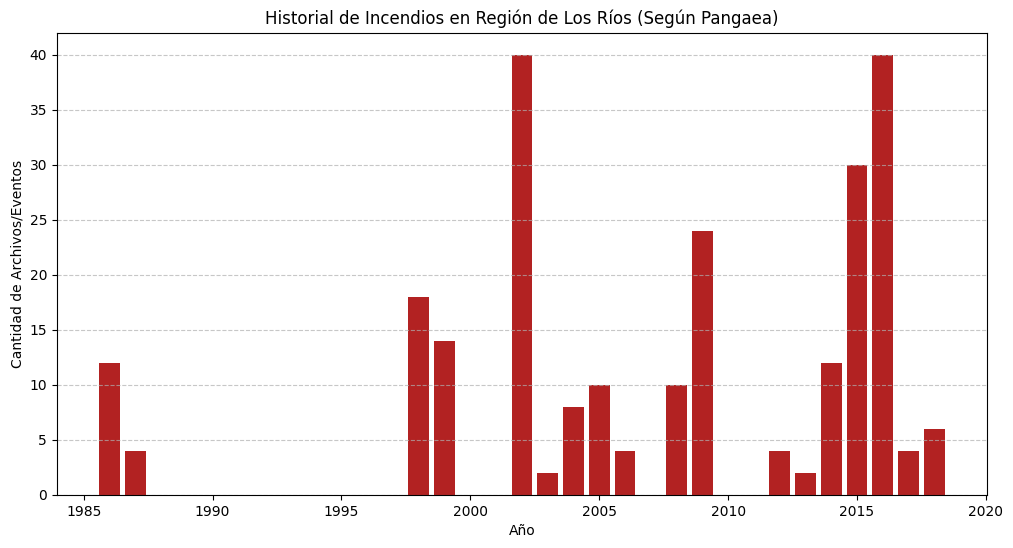

💡 Hallazgo: Este gráfico permite identificar los años más críticos antes de la simulación.


In [5]:
print("--- ANÁLISIS TEMPORAL DE INCENDIOS (PANGAEA) ---")

# Ruta base de Pangaea
base_pangaea = os.path.join(RAW_DIR, "incendios_pangaea/Fire_CL-LR_LosRios")

# Lista para guardar los datos del resumen
stats_incendios = []

# Buscar carpetas que tengan años (ej: ..._2017)
carpetas_anos = sorted(glob.glob(os.path.join(base_pangaea, "*_*")))

for carpeta in carpetas_anos:
    # Extraer el año del nombre de la carpeta
    try:
        ano = int(carpeta.split("_")[-1])
        # Contar cuántos archivos .shp hay dentro (cada shp es un incendio o un grupo)
        archivos_shp = glob.glob(os.path.join(carpeta, "*.shp"))
        cantidad = len(archivos_shp)
        
        stats_incendios.append({"Año": ano, "Incendios_Registrados": cantidad})
    except ValueError:
        continue # Saltar carpetas que no terminen en número

# Crear DataFrame para graficar
df_historia = pd.DataFrame(stats_incendios)

if not df_historia.empty:
    # Gráfico de barras: Serie Temporal
    plt.figure(figsize=(12, 6))
    plt.bar(df_historia["Año"], df_historia["Incendios_Registrados"], color='firebrick')
    plt.title("Historial de Incendios en Región de Los Ríos (Según Pangaea)")
    plt.xlabel("Año")
    plt.ylabel("Cantidad de Archivos/Eventos")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()
    
    print("💡 Hallazgo: Este gráfico permite identificar los años más críticos antes de la simulación.")
else:
    print("⚠️ No se encontraron carpetas de años válidas.")